Matched against references using Gabor filter banks:
original: person 1, match result: person 1


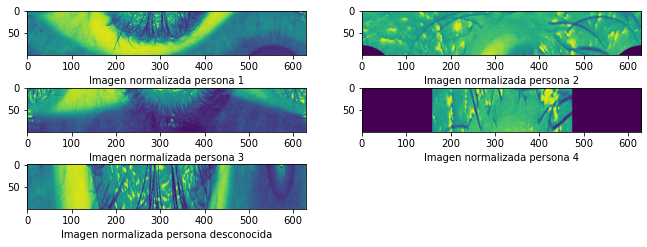

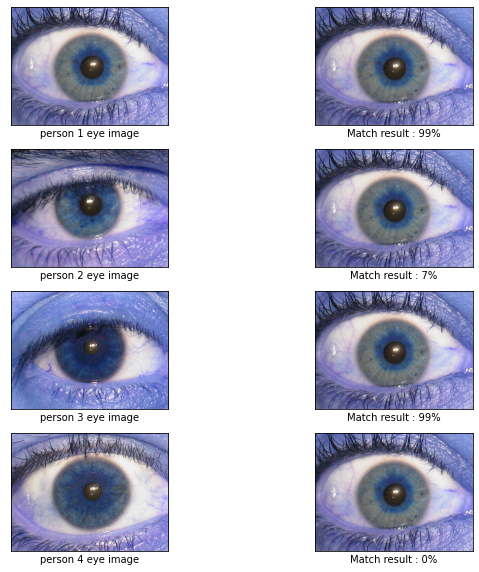

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2,os,scipy
from skimage.morphology import black_tophat,disk
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

def rgb2gray(rgb):
      return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
def center(gaussian_img):
    edges = cv2.Canny(gaussian_img,50,100)
    cimg = cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)
    #plt.imshow(cimg)
    circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
    circles = np.uint16(np.around(circles))
    center=circles[0,:]
    y=int(center[0,0])
    x=int(center[0,1])
    r=int(center[0,2])
    return (x,y,r)

def radius(gaussian_img):
    edges = cv2.Canny(gaussian_img,20,20)
    cimg = cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)
    circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
    circles = np.uint16(np.around(circles))
    circles=circles[0,:]
    circles = np.uint16(np.around(circles))
    #plt.imshow(circles)
    radiuses=circles[:,2]
    x=[]
    for i in range(len(radiuses)):
        if(radiuses[i]<115 and radiuses[i]>100):
            x.append(radiuses[i])
    return int(np.mean(x))
def norm_image(path):
    path = os.path.join(os.getcwd(),path)
    image=np.array(cv2.imread(path))
    temp_img=gray_img=np.uint8(rgb2gray(image))
    selem = disk(6)
    b_tophat = black_tophat(gray_img, selem)
    resultant_img=b_tophat+gray_img
    median_img = cv2.medianBlur(resultant_img,5)
    gaussian_img=scipy.ndimage.filters.gaussian_filter(median_img,
                                                       sigma=1.90, order=0,output=None,
                                                       mode='reflect',
                                                       cval=0.0, truncate=4.0)
    xc,yc,r=center(gaussian_img)
    R=radius(gaussian_img)
    theta = np.arange(0.00, np.pi*2, 0.01) #theta
    rng=np.arange(0,100)
    norm_img=np.zeros((rng.size,theta.size))
    for t in theta:
        for rc in rng:
            mc=(R-r)*(rc)/100+r
            x=int(xc+mc*np.cos(t))
            y=int(yc+mc*np.sin(t))
            try:
                norm_img[rc,np.where(theta==t)]=temp_img[x,y]
            except Exception as e:
                pass
    return norm_img

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

percentage_array=[]
def match(feats, ref_feats):
    max_error=15000000
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        percentage=int((max_error-error)*100/max_error)
        if percentage <= 0:
            percentage = 0
        percentage_array.append(percentage)
#         print(str(percentage)+" %")
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


image_names=[r"C:\Users\wob19\Music\UN_TecnicasDeInteligenciaArtificial\Proyecto\Images\eyes\Img_8_1_1.bmp",
             r"C:\Users\wob19\Music\UN_TecnicasDeInteligenciaArtificial\Proyecto\Images\eyes\Img_5_1_3.bmp",
             r"C:\Users\wob19\Music\UN_TecnicasDeInteligenciaArtificial\Proyecto\Images\eyes\Img_7_1_1.bmp",
             r"C:\Users\wob19\Music\UN_TecnicasDeInteligenciaArtificial\Proyecto\Images\eyes\Img_1_1_1.bmp"]

person1=norm_image(image_names[0])
person2=norm_image(image_names[1])
person3=norm_image(image_names[2])
person4=norm_image(image_names[3])

person_names = ('person 1', 'person 2', 'person 3','person 4')
unknown_img = r"C:\Users\wob19\Music\UN_TecnicasDeInteligenciaArtificial\Proyecto\Images\eyes\Img_8_1_2.jpg"

images = (person1,person2,person3,person4)

f = plt.figure()
f.set_figwidth(11)

plt.subplot(3,2,1)
plt.imshow(person1)
plt.xlabel("Imagen normalizada persona 1")
plt.subplot(3,2,2)
plt.imshow(person2)
plt.xlabel("Imagen normalizada persona 2")
plt.subplot(3,2,3)
plt.imshow(person3)
plt.xlabel("Imagen normalizada persona 3")
plt.subplot(3,2,4)
plt.imshow(person4)
plt.xlabel("Imagen normalizada persona 4")

# prepare reference features
ref_feats = np.zeros((4, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(person1, kernels)
ref_feats[1, :, :] = compute_feats(person2, kernels)
ref_feats[2, :, :] = compute_feats(person3, kernels)
ref_feats[3, :, :] = compute_feats(person4, kernels)

print('Matched against references using Gabor filter banks:')
print('original: person 1, match result: ', end='')
unknown_person_norm_image=norm_image(unknown_img)
feats = compute_feats(unknown_person_norm_image, kernels)
print(person_names[match(feats, ref_feats)])

plt.subplot(3,2,5)
plt.imshow(unknown_person_norm_image)
plt.xlabel("Imagen normalizada persona desconocida")

plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(person_names[i]+" eye image")
    plt.imshow(np.array(cv2.imread(image_names[i])),cmap ='gray')
    plt.subplot(4,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Match result : "+str(percentage_array[i])+"%")
    plt.imshow(np.array(cv2.imread(unknown_img)),cmap ='gray')
plt.show()